# **Prediction of a Stocks Portfolio Return using Recurrent Neural Networks** (Part 2)
_____

Author: **Daniel Eduardo López**

**20/01/2023**

<a href="https://www.linkedin.com/in/daniel-eduardo-lopez"><font size="-1">LinkedIn</font></a> 

<a href="https://github.com/DanielEduardoLopez"><font size="-1">GitHub </font></a>

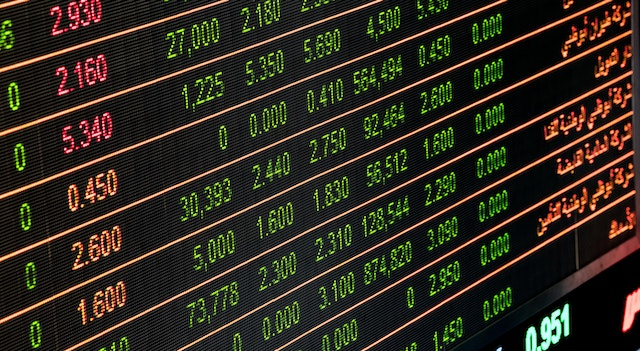

<font size="-1">Image Credit: <a href="https://www.pexels.com/es-es/foto/numeros-en-el-monitor-534216/"> Pixabay </a></font>


___
## **1. Goal**
___

The purpose of the present notebook is to build, train and evaluate a Recurrent Neural Network to predict the return of the optimized stocks portfolio built in the <a href="https://github.com/DanielEduardoLopez/PortfolioReturn/blob/main/1_PortfolioReturn_DataCollectionPrep.ipynb">previous section.</a>


___
## **2. Data Modeling**
___

In the present section, a Recurrent Neural Network was built and trained to predict the return of the optimized stocks portfolio.

In [1]:
# Loading Requirements Text File
#!pip install -r requirements.txt

In [2]:
# Libraries installation
!pip install pip==21.2 # Pip version for successfully using the method get_installed_distributions
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00
Reason for being yanked: See https://github.com/pypa/pip/issues/8711
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.3 MB/s 
  distutils: /usr/local/include/python3.8

In [3]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Lambda
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from IPython.display import set_matplotlib_formats
from pip._internal.utils.misc import get_installed_distributions
import sys

In [4]:
# Setting theme and plot resolution
sns.set_theme(context = 'notebook', style = 'darkgrid')
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300
set_matplotlib_formats('svg')

# Setting default plot's aesthetics
plotfontcolor = 'dimgray'
mpl.rcParams['text.color'] = plotfontcolor
mpl.rcParams['axes.labelcolor'] = plotfontcolor
mpl.rcParams['xtick.color'] = plotfontcolor
mpl.rcParams['ytick.color'] = plotfontcolor

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/DanielEduardoLopez/PortfolioReturn/main/Hist_Opt_Returns.csv")
df.head()

,Date,Returns
0,2020-01-03,0.019255
1,2020-01-06,0.038800
2,2020-01-07,0.049205
3,2020-01-08,-0.021945
4,2020-01-09,-0.006627


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     727 non-null    object 
 1   Returns  727 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.5+ KB


In [49]:
df.describe()

,Returns
count,727.000000
mean,0.002920
std,0.046334
min,-0.210628
25%,-0.022199
50%,0.001768
75%,0.024981
max,0.198948


Thus, the mean return of the portfolio is 0.292%.

In [6]:
def windowed_dataset(series, window_size = 20, batch_size = 32, shuffle_buffer = 1000):
  """
  Creates a windowed dataset of a time series for the input into a RNN model with Tensorflow.

  Parameters

  series: Numpy series with the time series data.
  window_size: Size of the subset of elements of the input time series data.
  batch_size: Size of the batch.
  shuffle_buffer: Buffer size. Should be greater than or equal to the lenght of the dataset.

  Returns

  dataset: Tensorflow dataset object.

  """
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  
  return dataset

In [7]:
# Creation of the input object dataset for the RNN model
series = df['Returns'].values

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

In [8]:
# Session Clearing and Setting of Random seeds
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#### **Model**
In order to predict the Portfolio Return, a RNN with the following architecture was proposed:
1. A first **Lambda layer** to convert the input windowed dataset into a tensor.
2. A first **Long Short-Term Memory layer** with 32 units.
3. A second **Long Short-Term Memory layer** with 32 units.
4. A **full connection layer** with 32 nodes and a ReLU activation function, and a dropout of 15%.
5. A **full connection layer** with 64 nodes and a ReLU activation function, and a dropout of 15%.
6. An **output layer** of 1 node.
7. An **Lambda layer** to scale the output by 100 units.

In [9]:
# Model

# Initialization of the RNN
model = Sequential()

# Transformation of the input dataset into a tensor
model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))

# LSTM
model.add(Bidirectional(LSTM(32, return_sequences=True)))

# LSTM
model.add(Bidirectional(LSTM(32)))

# Full Connection
model.add(Dense(32, input_shape=[window_size], activation="relu"))
model.add(Dropout(0.15))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.15))
model.add(Dense(1))

# Output Scaling
model.add(Lambda(lambda x: x * 100.0))

#### **Learning Rate Optimization**
Furthermore, in order to get better predictions, the learning rate was optimized.

In [10]:
# Learning Rate Optimization

# Pivot Learning Rate value
pivot_lr = 1e-8

# Learning Rate will marginally increase with each epoch
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
                lambda epoch: pivot_lr * 10**(epoch / 20)) 

# Gradient descent (with momentum) optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate = pivot_lr, momentum = 0.9)

In [11]:
# Model compilation
model.compile(loss = tf.keras.losses.Huber(), # Huber loss between y_true & y_pred
              optimizer = optimizer, 
              metrics = ['mse', 'mae'])

In [12]:
# Fitting of the model
history = model.fit(dataset, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
23/23 [==============================] - 18s 98ms/step - loss: 0.0197 - mse: 0.0393 - mae: 0.1503 - lr: 1.0000e-08
Epoch 2/100
23/23 [==============================] - 2s 83ms/step - loss: 0.0185 - mse: 0.0371 - mae: 0.1455 - lr: 1.1220e-08
Epoch 3/100
23/23 [==============================] - 2s 78ms/step - loss: 0.0169 - mse: 0.0338 - mae: 0.1378 - lr: 1.2589e-08
Epoch 4/100
23/23 [==============================] - 2s 70ms/step - loss: 0.0169 - mse: 0.0338 - mae: 0.1336 - lr: 1.4125e-08
Epoch 5/100
23/23 [==============================] - 2s 67ms/step - loss: 0.0151 - mse: 0.0303 - mae: 0.1256 - lr: 1.5849e-08
Epoch 6/100
23/23 [==============================] - 2s 66ms/step - loss: 0.0148 - mse: 0.0296 - mae: 0.1217 - lr: 1.7783e-08
Epoch 7/100
23/23 [==============================] - 2s 65ms/step - loss: 0.0137 - mse: 0.0274 - mae: 0.1152 - lr: 1.9953e-08
Epoch 8/100
23/23 [==============================] - 1s 35ms/step - loss: 0.0122 - mse: 0.0243 - mae: 0.1094 - lr: 2.

In [13]:
# Conversion of the history keras object into a dataframe
lr_opt_df = pd.DataFrame.from_dict(history.history)
lr_opt_df.head()

,loss,mse,mae,lr
0,0.019652,0.039303,0.150263,1.000000e-08
1,0.018532,0.037065,0.145530,1.122018e-08
2,0.016893,0.033787,0.137775,1.258925e-08
3,0.016900,0.033800,0.133636,1.412538e-08
4,0.015139,0.030277,0.125578,1.584893e-08


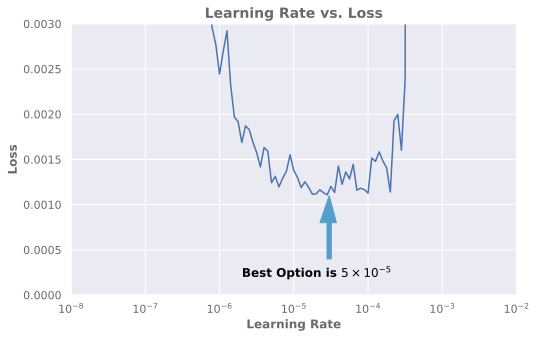

In [71]:
# Plot of the Learning Rate vs. Loss
plt.figure(figsize = (8,5))
g = sns.lineplot(data = lr_opt_df, x = 'lr', y = 'loss')
g.set(xscale='log')
plt.title('Learning Rate vs. Loss', fontweight = 'bold', size = 14)
plt.ylabel('Loss', fontweight = 'bold', size = 12)
plt.xlabel('Learning Rate', fontweight = 'bold', size = 12)
plt.text(2e-6, 0.00020, r"Best Option is $5\times10^{-5}$", fontweight = 'bold', color = 'black')
plt.arrow(3e-5, 0.0004, 0, 0.0007, width = 0.000004, head_length = 0.0003, 
          head_width = 0.000015, length_includes_head = True, shape = 'full',
          color = sns.color_palette('Blues_r')[2])
plt.axis([1e-8, 1e-2, 0, 0.003])
plt.savefig('Fig6_LearningRateOpt.png',  bbox_inches = 'tight')
plt.show()

Thus, from the plot above,  the approximate best learning rate is:

$$5\times10^{-5}$$

In [31]:
# Optimal Learning Rate
lr = 5e-5

#### **Model Training**
Once the architecture of the RNN was defined and an optimal learning rate was selected, the model was trained using **MSE** as the loss function, the **gradient descent with momentum** as the optimizer and keeping track of the **MAE** metric too. 500 epochs were used.

In [33]:
# Cleaning of the Keras Global State
tf.keras.backend.clear_session()

In [34]:
# Model compilation
model.compile(loss = "mse", optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum= 0.9), metrics=["mae", tfa.metrics.RSquare()])

In [35]:
# Model Fitting
history = model.fit(dataset, epochs = 500, verbose = 1)

Epoch 1/500
23/23 [==============================] - 8s 33ms/step - loss: 0.0023 - mae: 0.0358 - r_square: -0.1100
Epoch 2/500
23/23 [==============================] - 1s 31ms/step - loss: 0.0022 - mae: 0.0349 - r_square: -0.0557
Epoch 3/500
23/23 [==============================] - 1s 34ms/step - loss: 0.0033 - mae: 0.0455 - r_square: -0.5897
Epoch 4/500
23/23 [==============================] - 1s 33ms/step - loss: 0.0026 - mae: 0.0369 - r_square: -0.2129
Epoch 5/500
23/23 [==============================] - 1s 34ms/step - loss: 0.0023 - mae: 0.0357 - r_square: -0.0843
Epoch 6/500
23/23 [==============================] - 1s 33ms/step - loss: 0.0035 - mae: 0.0469 - r_square: -0.6639
Epoch 7/500
23/23 [==============================] - 1s 34ms/step - loss: 0.0046 - mae: 0.0552 - r_square: -1.2025
Epoch 8/500
23/23 [==============================] - 1s 31ms/step - loss: 0.0029 - mae: 0.0415 - r_square: -0.3984
Epoch 9/500
23/23 [==============================] - 1s 33ms/step - loss: 0.0052

#### **Predictions**

To generate the predictions, the original time series data was first split into a training and a testing set. To do so, 80% of the data was used for the training set and 20% for the testing set.

In [39]:
# Creation of the training and testing sets
time = np.arange(len(series), dtype="float32")
split_time = int(round(len(series) * 0.80, 0))
time_train = time[:split_time]
x_train = series[:split_time]
time_test = time[split_time:]
x_test = series[split_time:]

In [40]:
# Forecasting
forecast = []
results = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Keeping only the predictions correspoding to the testing set
forecast = forecast[split_time-window_size:] 
predictions = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 20ms/step


In [63]:
# Transforming predictions array into a pandas dataframe
predictions_df = df.copy()
predictions_df = predictions_df.iloc[(len(predictions_df) - len(predictions)):]
predictions_df['Prediction'] = predictions
predictions_df = predictions_df.rename(columns = {'Returns': 'Actual'})
predictions_df = pd.melt(predictions_df, id_vars = 'Date', var_name = 'Return', 
                         value_name = 'Value', ignore_index = True)
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])
predictions_df = predictions_df.sort_values("Date").reset_index().drop(columns = 'index')
predictions_df.head()

,Date,Return,Value
0,2022-06-02,Actual,-0.092193
1,2022-06-02,Prediction,0.007362
2,2022-06-03,Prediction,0.007362
3,2022-06-03,Actual,0.016047
4,2022-06-06,Actual,0.002546


In [64]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    290 non-null    datetime64[ns]
 1   Return  290 non-null    object        
 2   Value   290 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.9+ KB


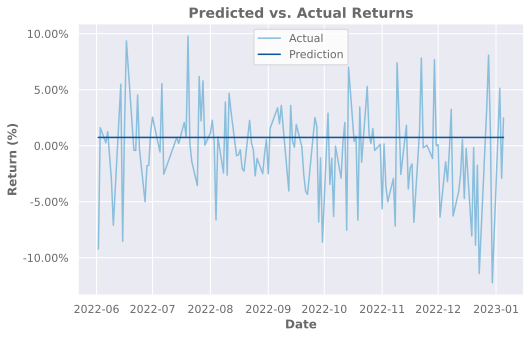

In [94]:
# Plot of the predictions vs actual values
colors = [sns.color_palette('Blues')[index] for index in [2,5]] #colors
plt.figure(figsize=(8, 5))
ax = sns.lineplot(data = predictions_df, x = 'Date', y = 'Value', hue = 'Return',
                 palette = colors)
plt.title('Predicted vs. Actual Returns', size = 14, fontweight = 'bold')
plt.xlabel("Date", size = 12, fontweight = 'bold')
plt.ylabel("Return (%)", size = 12, fontweight = 'bold')
sns.move_legend(ax, "upper center", facecolor = 'white', title=None)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
#ax.axhline(y = 0, color = 'black', linewidth = 1, linestyle = '--')
plt.savefig('Fig7_Predictions.png',  bbox_inches = 'tight')
plt.show()

In view of the plot above, the RNN has predicted a constant value for all the time points, i.e., a constant return of 0.7362%.

___
## **3. Evaluation**
___

In the present section, the predictions of the Recurrent Neural Network were evaluated using the RMSE and the MAE.